## Init load fast ai

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 48 kB 3.3 MB/s 
     |████████████████████████████████| 1.2 MB 40.1 MB/s 
     |████████████████████████████████| 189 kB 40.0 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 266 kB/s 
     |████████████████████████████████| 558 kB 44.1 MB/s 
     |████████████████████████████████| 130 kB 45.2 MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.all import *

## Multi Classification

In [ ]:
path = untar_data(URLs.PASCAL_2007)

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

DataBlock将原始数据转化为训练用的标准结构化数据(提供训练用的 `get_x`, `get_y`函数, 将数据拆分为`train`, `validation`)
通过DataBlock可以创建
* Dataset 转化后的标准的结构化数据集
* DataLoader 数据集的数据流, 提供分批的小块数据(mini-batch)以供训练

In [ ]:
dblock = DataBlock(get_x=lambda r: r['fname'], get_y=lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0], dsets.valid[0]

(('008663.jpg', 'car person'), ('002613.jpg', 'bottle person'))

In [ ]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

对于多目标识别，`get_y`函数返回多个目标

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ') #multi label
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x332,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

找到对应的类别描述

In [ ]:
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

自定义测试集和验证集拆分

In [ ]:
def splitter(df):
  train=df.index[~df['is_valid']].tolist()
  valid=df.index[df['is_valid']].tolist()
  return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

更进一步, 为了保证图片大小一致, 随机裁剪大小

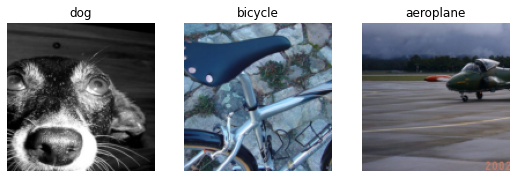

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
x,y = to_cpu(dls.train.one_batch())
actives = learn.model(x)
actives.shape

torch.Size([64, 20])

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(actives, y)
loss

TensorMultiCategory(1.0660, grad_fn=<AliasBackward0>)

定义Accuracy函数, 构建Learner

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learn.fine_tune??

In [ ]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.943709,0.681508,0.244781,00:46
1,0.822394,0.557362,0.292450,00:45
2,0.603104,0.204323,0.813227,00:43
3,0.362135,0.124706,0.944203,00:57


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136444,0.114963,0.949064,01:03
1,0.117229,0.106772,0.950159,01:03
2,0.098739,0.102560,0.951693,01:02


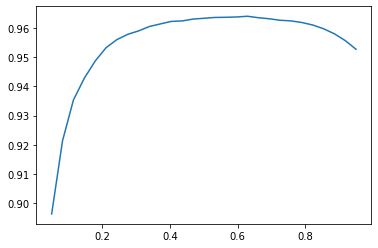

In [ ]:
preds,targs = learn.get_preds()
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

## Regression problem

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path

In [ ]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img_files[0], img2pose(img_files[0])

(Path('24/frame_00070_rgb.jpg'), Path('24/frame_00070_pose.txt'))

In [ ]:
#p = path/'24'/'frame_00070_pose.txt'
#Path.BASE_PATH=""
#p

Path('/root/.fastai/data/biwi_head_pose/24/frame_00070_pose.txt')

In [ ]:
#!head -10 /root/.fastai/data/biwi_head_pose/24/frame_00070_pose.txt

0.830347 0.000465044 0.557247 
-0.19014 0.940222 0.28254 
-0.523805 -0.340561 0.780799 

80.9924 2.3828 945.28 



In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img_files[0], img2pose(img_files[0])

(Path('24/frame_00070_rgb.jpg'), Path('24/frame_00070_pose.txt'))

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240, 320)), #aug must apply on center too
                Normalize.from_stats(*imagenet_stats)]
)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


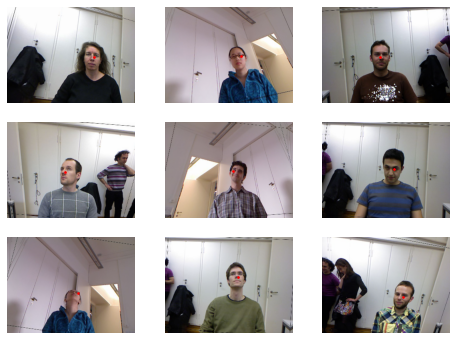

In [ ]:
dls = dblock.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
xb, yb=dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [ ]:
yb[0]

In [ ]:
learn = cnn_learner(dls, resnet18, y_range(-1,1))